# Preprocessing

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [45]:
import os
import datetime as dt

import copy
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

tf.keras.utils.set_random_seed(
    987654321
)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [46]:
# Macros
BY_ZONE = False # True if you want grouping by zones (Nord, Centro, Sud, Sardegna)
BY_REGION = True # True if you want to keep single regions

In [47]:
# File name
#file_path = "../Data/dpc-covid19-ita-regioni.csv"
file_path = '../Data/dpc-covid19-ita-regioni.csv'
features_list = ["totale_ospedalizzati", "nuovi_positivi", "dimessi_guariti", "deceduti"]

# Load data
df_all = pd.read_csv(
    file_path,
    usecols = ["data", "denominazione_regione", "nuovi_positivi", "totale_ospedalizzati", "dimessi_guariti", "deceduti"],
    parse_dates = True,
)

# Convert data coulumn
df_all["data"] = pd.to_datetime(df_all["data"]).dt.date

# Keep only latest data wrt cut_date
cut_date_3 = dt.date(2021, 3, 1)    #(2022, 1, 10)
cut_date_2 = dt.date(2024, 12, 1)   #(2021, 12, 1)
cut_date_1 = dt.date(2024, 2, 1)    #(2021, 2, 1)  

df_all = df_all.loc[ ((df_all["data"] >= cut_date_1) & (df_all["data"] <= cut_date_2)) | (df_all["data"] >= cut_date_3)]

In [48]:
# Create 4 groups of regions
# NON SONO SICURO PERO': LUI CHIEDE ESPRESSAMENTE REGIONI!
if BY_ZONE:
    
    Nord = ["Emilia-Romagna", 
            "Friuli Venezia Giulia", 
            "Lombardia", 
            "P.A. Bolzano", 
            "P.A. Trento", 
            "Piemonte", 
            "Toscana", 
            "Valle d'Aosta",
            "Veneto"
           ]
    Centro = ["Abruzzo",
              "Lazio",
              "Marche",
              "Molise",
              "Umbria",
             ]

    Sud = ["Basilicata",
           "Calabria",
           "Campania",
           "Puglia",
           "Sicilia"
          ]

    Sardegna = ["Sardegna"]

    df_Nord = df_all.loc[df_all['denominazione_regione'].isin(Nord)]
    df_Nord.pop("denominazione_regione")
    df_Nord = df_Nord.groupby(["data"]).sum()
    df_Nord.reset_index(drop=False, inplace=True)

    df_Centro = df_all.loc[df_all['denominazione_regione'].isin(Centro)]
    df_Centro.pop("denominazione_regione")
    df_Centro = df_Centro.groupby(["data"]).sum()
    df_Centro.reset_index(drop=False, inplace=True)

    
    df_Sud = df_all.loc[df_all['denominazione_regione'].isin(Sud)]
    df_Sud.pop("denominazione_regione")
    df_Sud = df_Sud.groupby(["data"]).sum()
    df_Sud.reset_index(drop=False, inplace=True)

    
    df_Sardegna = df_all.loc[df_all['denominazione_regione'].isin(Sardegna)]
    df_Sardegna.pop("denominazione_regione")
    df_Sardegna = df_Sardegna.groupby(["data"]).sum()
    df_Sardegna.reset_index(drop=False, inplace=True)

In [49]:
df_tot = pd.DataFrame()

if BY_REGION:
    
    df_by_region = dict() # dictionary containing data for each regione

    regions = list(df_all.loc[:,"denominazione_regione"].unique())
    
    for reg in regions:
        
        df_by_region[reg] = df_all.loc[df_all["denominazione_regione"] == reg]
        columns_={"totale_ospedalizzati": "totale_ospedalizzati_" + reg, 
                 "nuovi_positivi": "nuovi_positivi_" + reg, 
                 "dimessi_guariti" : "dimessi_guariti_" + reg, 
                 "deceduti": "deceduti_" + reg}
        df_by_region[reg].pop("denominazione_regione")
        df_by_region[reg] = df_by_region[reg].rename(columns = columns_)
        df_by_region[reg].set_index("data", inplace = True)
       
        if df_tot.shape[0] == 0:
            df_tot = df_by_region[reg].iloc[:,1:]
        else:
            df_tot = pd.concat([df_tot, df_by_region[reg].iloc[:,1:]], axis=1)


 # RNN

## Tensorflow modified classes 

In [50]:
# FUNCTIONALITIES

# Window generator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df=None, test_df=None,
               label_columns=None, batch_size = 32):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size
    
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# plot function
def plot(self, model=None, plot_col='nuovi_positivi_Lombardia', max_subplots=32):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.figure()
    #plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# make tf.dataset
def make_dataset(self, data, batch_size):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# Properties
@property
def train(self):
  return self.make_dataset(self.train_df, self.batch_size)

@property
def val(self):
  return self.make_dataset(self.val_df, self.batch_size)

@property
def test(self):
  return self.make_dataset(self.test_df, self.batch_size)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Training-Validation-Test sets creation

array([<AxesSubplot:xlabel='data'>, <AxesSubplot:xlabel='data'>,
       <AxesSubplot:xlabel='data'>, <AxesSubplot:xlabel='data'>],
      dtype=object)

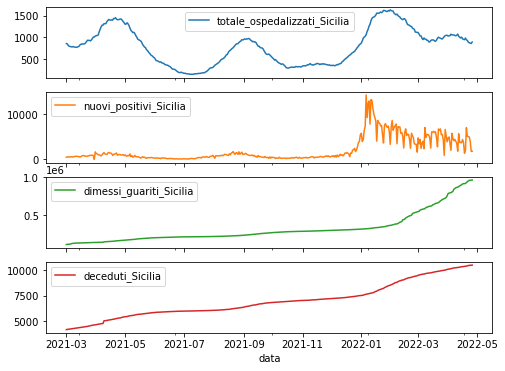

In [51]:
df_by_region['Sicilia'].plot(subplots=True)

In [52]:
regions_train = ["Sicilia"]   # name of regions to train simultaneously

NORMALIZATION = False
PCT_CHANGE = True
DIFF = False
APPLY_SMOOTHING = False
VALIDATION = True

all_df = dict()
all_df_1 = dict()
all_df_2 = dict()
train_df = dict() # dictionary of training dataFrames 
if VALIDATION:
    val_df = dict() # dictionary of validation dataframes
test_df = dict() # dictionary of test dataframes

OUT_STEPS = 7 # length of prediction horizon (OUTPUT OF NN)
IN_STEPS = 28 # length of input horizon (INPUT OF NN)
SHIFT = OUT_STEPS # Can be different from OUT_STEPS (to be used with care)

time_steps_for_test = OUT_STEPS # Numbers of days to keep out for the validation (in principle it should be of length: OUT_STEP+IN_STEPS), but we can use just OUT_STEPS
if VALIDATION:
    time_steps_for_validation = IN_STEPS+OUT_STEPS

# FOR THE NORMALIZATION I USE THE MEANS OF TRAIN FOR BOTH TRAINING AND TESTING
for reg in regions_train:

    mean = 0
    std = 1

    if PCT_CHANGE:

      all_df_1[reg] = copy.deepcopy(df_by_region[reg].loc[ ((df_by_region[reg].index >= cut_date_1) & (df_by_region[reg].index <= cut_date_2)) ])
      all_df_2[reg] = copy.deepcopy(df_by_region[reg].loc[ (df_by_region[reg].index >= cut_date_3)])
      all_df_1[reg] = all_df_1[reg].pct_change().dropna()
      all_df_2[reg] = all_df_2[reg].pct_change().dropna()
      all_df[reg] = pd.concat([all_df_1[reg], all_df_2[reg]], axis = 0, ignore_index = True)
    
    if DIFF:

      all_df_1[reg] = copy.deepcopy(df_by_region[reg].loc[ ((df_by_region[reg].index >= cut_date_1) & (df_by_region[reg].index <= cut_date_2)) ])
      all_df_2[reg] = copy.deepcopy(df_by_region[reg].loc[ (df_by_region[reg].index >= cut_date_3)])
      all_df_1[reg] = all_df_1[reg].diff().dropna()
      all_df_2[reg] = all_df_2[reg].diff().dropna()
      all_df[reg] = pd.concat([all_df_1[reg], all_df_2[reg]], axis = 0, ignore_index = True)
    
    if NORMALIZATION:
      mean = all_df[reg].iloc[:-time_steps_for_test,:].mean()
      std = all_df[reg].iloc[:-time_steps_for_test,:].std()
      
    all_df[reg] = ( all_df[reg] - mean ) / std

    if APPLY_SMOOTHING:
        
        window_length = 3 # MUST BE ODD; if you put 7 you obtain just the trend
        polyorder = 1 # Try also 2, 3, ...
        
        all_df[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)] = savgol_filter(
                all_df[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)],
                window_length,
                polyorder
            )
    
    if VALIDATION:
        train_df[reg] = all_df[reg].iloc[:-(time_steps_for_test + time_steps_for_validation),:]
        val_df[reg] = all_df[reg].iloc[ -(time_steps_for_test + time_steps_for_validation) : -time_steps_for_test, :]
        test_df[reg] = all_df[reg].iloc[-time_steps_for_test:,:]
    else:
        train_df[reg] = all_df[reg].iloc[:-time_steps_for_test,:]
        test_df[reg] = all_df[reg].iloc[-time_steps_for_test:,:]


    train_df[regions_train[0]] = train_df[regions_train[0]].replace([np.inf, -np.inf], np.nan).dropna()

windows = dict() # dictionary of windows for each region
    
for reg in regions_train:
    if VALIDATION:
        windows[reg] =  WindowGenerator(input_width=IN_STEPS,
                                        label_width=OUT_STEPS,
                                        shift=SHIFT,
                                        train_df = train_df[reg],
                                        val_df = val_df[reg],
                                        batch_size = 8, ### DEAFULT = 32; can be modified by hand being careful
                                        #label_columns=['{}_{}'.format("nuovi_positivi", reg)] ### labels to train; we might split the training for the features since it may help the models...
                                        )
    else:
        windows[reg] =  WindowGenerator(input_width=IN_STEPS,
                                label_width=OUT_STEPS,
                                shift=SHIFT,
                                train_df = train_df[reg],
                                batch_size = 1, ### DEAFULT = 32; can be modified by hand being careful
                                #label_columns=['{}_{}'.format("nuovi_positivi", reg)] ### labels to train; we might split the training for the features since it may help the models...
                                )
        
def plot_feature(reg, feature, model = None, max_figures = 3):
    windows[reg].plot(model = model, plot_col = "{}_{}".format(feature, region), max_subplots=max_figures)
    plt.xticks(rotation=90)
    print("To view all the figures, increase max_figures")

In [53]:
#Per Sicilia 

train_df[regions_train[0]] = train_df[regions_train[0]].replace([np.inf, -np.inf], np.nan).dropna()
train_df[regions_train[0]][train_df[regions_train[0]].isna().any(axis=1)]
train_df[regions_train[0]] = train_df[regions_train[0]].dropna()

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

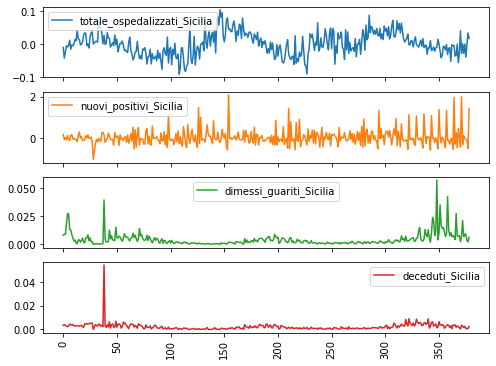

In [54]:
# check the training
train_df[regions_train[0]].plot(subplots=True)
plt.xticks(rotation=90)

In [15]:
# check the smoothing

import copy

window_length = 3 # MUST BE ODD; if you put 7 you obtain just the trend
polyorder = 1 # Try also 2, 3, ...

savgol_smooth = copy.deepcopy(train_df)

savgol_smooth[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)] = savgol_filter(
                savgol_smooth[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)],
                window_length,
                polyorder
            )

window_smooth = train_df[reg]['nuovi_positivi_Lombardia'].rolling(window=2).mean()

train_df[regions_train[0]]['nuovi_positivi_Lombardia'].plot(label = 'Original')
savgol_smooth[reg]['nuovi_positivi_Lombardia'].plot(label = 'savgol')
window_smooth.dropna().plot(label="Rolling Window (2 days)")
plt.legend()
plt.xticks(rotation=90)

KeyError: 'nuovi_positivi_Lombardia'

To view all the figures, increase max_figures


<Figure size 864x576 with 0 Axes>

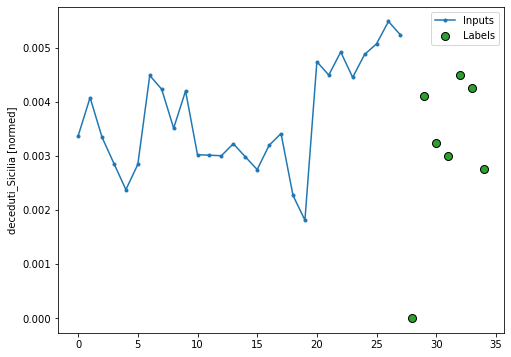

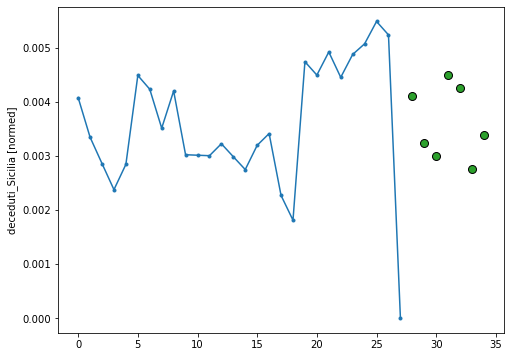

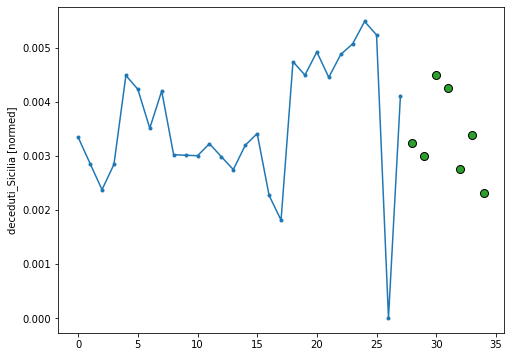

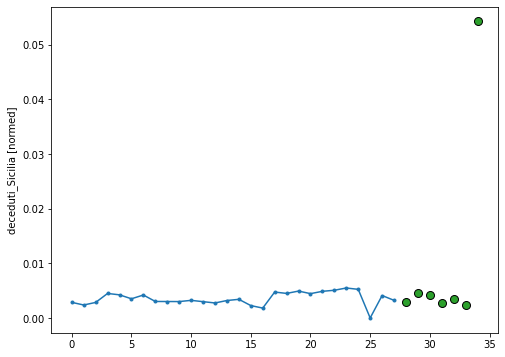

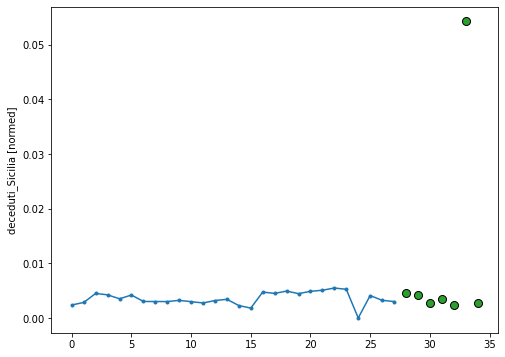

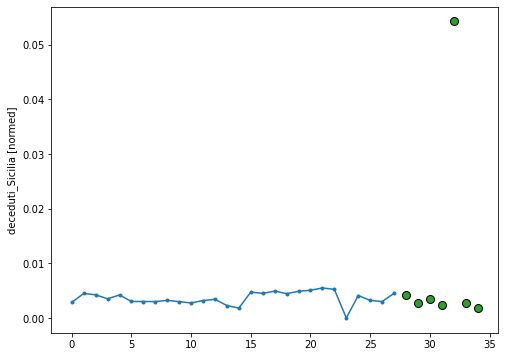

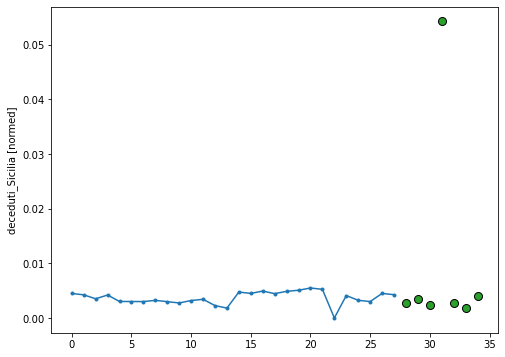

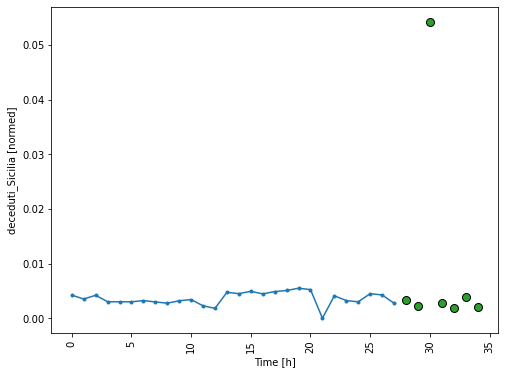

In [17]:
# Plot for viewing the batches
region = "Sicilia"
feature = "deceduti" #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati
plot_feature(region, feature, max_figures=10)

In [55]:
# Creation Training set for RNN

# Single region
if len(regions_train) == 1:

    X_train = windows[regions_train[0]].train
    
    try:
        X_val =  windows[regions_train[0]].val
    except:
        print("Cannot create X_val for trainf with the given window size or val_df not present")
        X_val = None

# Multiple regions
elif len(regions_train) > 1:
    
    print("More than one region...")
    
    for i in range(len(regions_train)-1):
        
        X_train = windows[regions_train[i]].train.concatenate(windows[regions_train[i+1]].train)
        
        try:
            X_val = windows[regions_train[i]].val.concatenate(windows[regions_train[i+1]].val)
        except:
            print("Cannot create X_val for trainf with the given window size or val_df not present")
            X_val = None

In [ ]:
# IN THIS WAY YOU CAN EXTRACT THE TRAINING DATASET (Solution to the problem highlighted by Nove)
# list(X_train.as_numpy_iterator())

## Multi-Steps

In [56]:
def compile_and_fit(model, X_train, MAX_EPOCHS = 200, X_val = None, patience=30):
  
  if X_val == None:
        monitor_loss = 'loss'
  else:
        monitor_loss = 'val_loss'
    
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_loss, 
                                                    patience=patience,
                                                    mode='min')
  
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.2,
                                                   patience=15, 
                                                   min_lr=0.0001)
  
  #easy_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/Othercomputers/Laptop/homework3/Data/checkpoint_' + reg + '.h5',
  #                                                     save_weights_only = False, save_freq = 'epoch', monitor = monitor_loss, mode='min', 
  #                                                     save_best_only = True, verbose = 1)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, epochs=MAX_EPOCHS,
                      validation_data=X_val,
                      callbacks=[early_stopping, reduce_lr])    #callbacks= [early_stopping, easy_checkpoint])

  return history

In [ ]:
# Run if we want to start from an old model
multi_lstm_model = tf.keras.models.load_model('/content/drive/Othercomputers/Laptop/homework3/Data/checkpoint_' + reg + '.h5')

In [57]:
# Current best model for LOMBARDIA

num_features = 4

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer = 'l2'), #activation='selu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [58]:
# model for LAZIO

num_features = 4

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False, kernel_regularizer = 'l2'), #activation='selu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [62]:
# model for SICILIA

num_features = 4

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer = 'l2'), #activation='selu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [75]:
multi_lstm_model.summary()    #right if gives error

ValueError: ignored

In [63]:
if VALIDATION:
    history = compile_and_fit(multi_lstm_model, X_train, X_val = X_val, MAX_EPOCHS = 500, patience = 10)
else:
    history = compile_and_fit(multi_lstm_model, X_train, MAX_EPOCHS = 500, patience = 10)

Epoch 1/500
43/43 [==============================] - 2s 14ms/step - loss: 0.0993 - mean_absolute_error: 0.0744 - val_loss: 0.0703 - val_mean_absolute_error: 0.0738 - lr: 0.0010
Epoch 2/500
43/43 [==============================] - 0s 8ms/step - loss: 0.0704 - mean_absolute_error: 0.0763 - val_loss: 0.0522 - val_mean_absolute_error: 0.0793 - lr: 0.0010
Epoch 3/500
43/43 [==============================] - 0s 8ms/step - loss: 0.0551 - mean_absolute_error: 0.0765 - val_loss: 0.0403 - val_mean_absolute_error: 0.0764 - lr: 0.0010
Epoch 4/500
43/43 [==============================] - 0s 8ms/step - loss: 0.0470 - mean_absolute_error: 0.0766 - val_loss: 0.0353 - val_mean_absolute_error: 0.0775 - lr: 0.0010
Epoch 5/500
43/43 [==============================] - 0s 8ms/step - loss: 0.0431 - mean_absolute_error: 0.0769 - val_loss: 0.0328 - val_mean_absolute_error: 0.0770 - lr: 0.0010
Epoch 6/500
43/43 [==============================] - 0s 8ms/step - loss: 0.0413 - mean_absolute_error: 0.0769 - val_los

To view all the figures, increase max_figures


<Figure size 864x576 with 0 Axes>

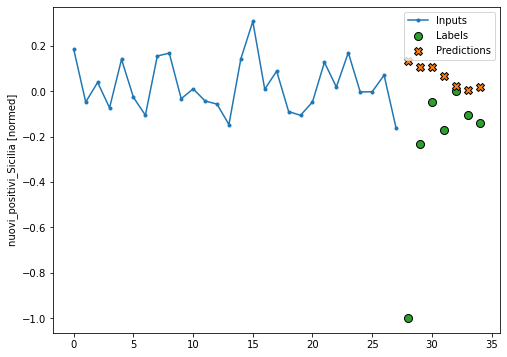

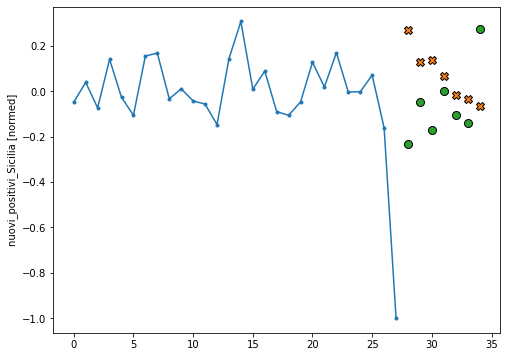

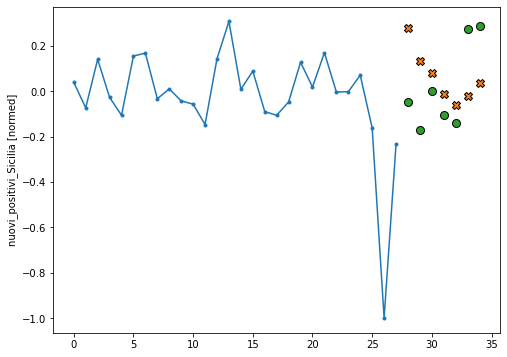

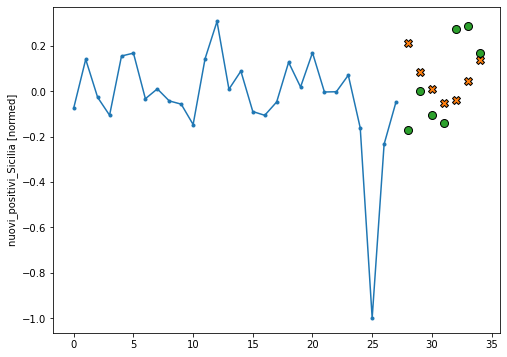

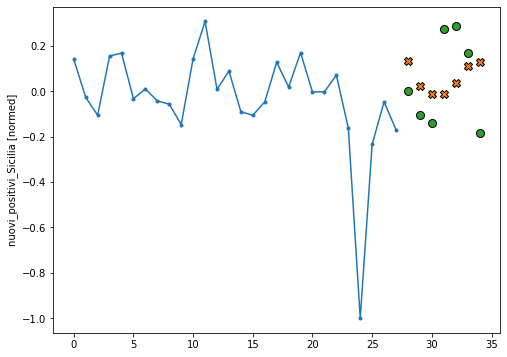

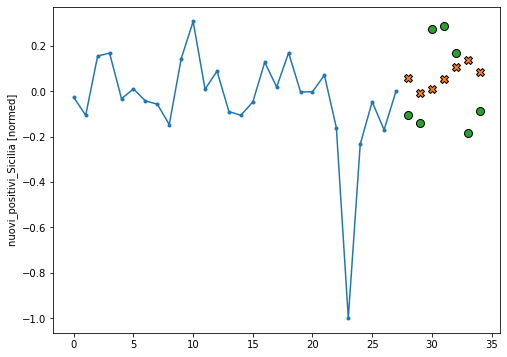

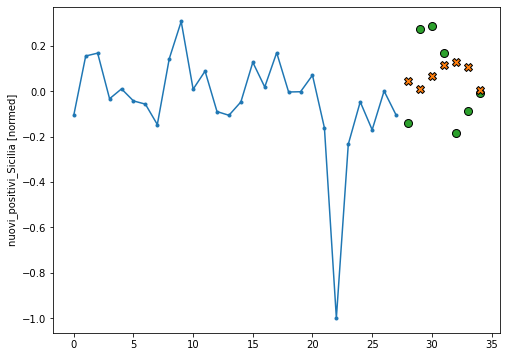

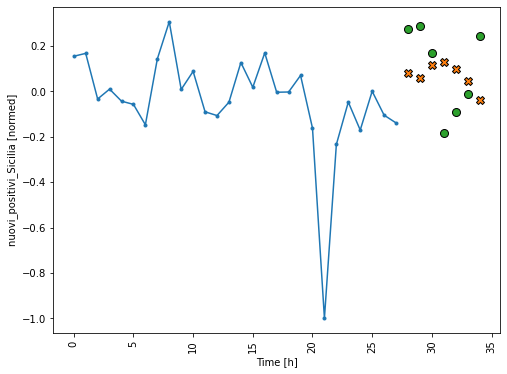

In [64]:
region = "Sicilia"
feature = "nuovi_positivi"  #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati #deceduti
plot_feature(region, feature, multi_lstm_model, 10)

# THE MODEL DOES NOT LEARN NUOVI_POSITVI: I THINK IT'S BEACUSE THE OTHER FEATURES HAVE AN INCREASING AND A DECREASING TREND,
# AND THE NN IS CONFUSED. FIRST LET'S SEE IF PCT_CHANGE OR DIFF CHANGE SOMETHING ...

In [65]:
region = "Sicilia"

if VALIDATION:
    pred_x_predict = multi_lstm_model(np.array(val_df[reg].iloc[-IN_STEPS:,:]).reshape(1, IN_STEPS, 4)) 
    pred_x_predict
else:
    pred_x_predict = multi_lstm_model(np.array(train_df[reg].iloc[-IN_STEPS:,:]).reshape(1, IN_STEPS, 4))
    pred_x_predict

In [66]:
pr = tf.squeeze(pred_x_predict)
prd = pd.DataFrame(pr.numpy())

idx = test_df[reg].index

predictions = prd.rename(columns={0: 'pred_totale_ospedalizzati_' + reg, 
                                  1: 'pred_nuovi_positivi_' + reg,
                                  2: 'pred_dimessi_guariti_' + reg,
                                  3: 'pred_deceduti_' + reg},
                          index={ 0: idx[0],
                                  1: idx[1],
                                  2: idx[2],
                                  3: idx[3],
                                  4: idx[4],
                                  5: idx[5],
                                  6: idx[6]})

In [38]:
predictions

,pred_totale_ospedalizzati_Sicilia,pred_nuovi_positivi_Sicilia,pred_dimessi_guariti_Sicilia,pred_deceduti_Sicilia
414,-0.009781,0.487678,0.002238,0.001890
415,-0.026434,0.271952,0.005307,0.001715
416,-0.024235,-0.054403,0.003545,0.001230
417,-0.005629,-0.326109,0.001017,0.001150
418,0.017648,-0.347805,-0.000877,0.000281
419,0.027746,-0.078477,-0.001538,0.001113
420,0.019735,0.389786,-0.000848,0.002792


In [39]:
test_df[reg]

,totale_ospedalizzati_Sicilia,nuovi_positivi_Sicilia,dimessi_guariti_Sicilia,deceduti_Sicilia
414,-0.043611,2.586945,0.015134,0.002795
415,-0.012725,-0.277936,0.010721,0.003075
416,-0.046187,-0.000591,0.009783,0.002587
417,-0.013514,-0.026005,0.008661,0.001338
418,-0.011416,-0.188107,0.001381,0.000668
419,-0.005774,-0.557299,0.001603,0.000668
420,0.037166,0.014631,0.001495,0.001048


In [40]:
concatenated_df = pd.concat([predictions, test_df[reg]], axis=1)

errors = pd.DataFrame()
for i in range(4):
  errors = pd.concat([errors, concatenated_df.iloc[:, i] - concatenated_df.iloc[:, i+4]], axis = 1, ignore_index=True)

In [41]:
errors    #ordine: totale_ospedalizzati	nuovi_positivi	dimessi_guariti	deceduti

,0,1,2,3
414,0.033830,-2.099267,-0.012896,-0.000905
415,-0.013709,0.549888,-0.005413,-0.001360
416,0.021952,-0.053812,-0.006238,-0.001357
417,0.007885,-0.300104,-0.007644,-0.000188
418,0.029063,-0.159698,-0.002258,-0.000387
419,0.033520,0.478823,-0.003140,0.000446
420,-0.017431,0.375154,-0.002343,0.001743


In [ ]:
# Nuovi positivi 

plt.scatter(predictions.index, predictions['pred_nuovi_positivi_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['nuovi_positivi_Lombardia'], label = 'Data')
plt.legend()

In [ ]:
# Totale ospedalizzati

plt.scatter(predictions.index, predictions['pred_totale_ospedalizzati_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['totale_ospedalizzati_Lombardia'], label = 'Data')
plt.legend()

In [ ]:
# Dimessi guariti

plt.scatter(predictions.index, predictions['pred_dimessi_guariti_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['dimessi_guariti_Lombardia'], label = 'Data')
plt.legend()

In [ ]:
# Deceduti 

plt.scatter(predictions.index, predictions['pred_deceduti_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['deceduti_Lombardia'], label = 'Data')
plt.legend()

In [ ]:
prova = np.ones((IN_STEPS,4)).reshape(1,IN_STEPS,4)
multi_lstm_model.predict(prova)

array([[[ 0.51139224, -0.42017663,  0.70290905,  2.0061364 ],
        [ 0.75077367,  0.03318462,  0.4497213 ,  2.1760144 ],
        [ 0.45952612, -0.10680426,  0.49523437,  2.1267207 ],
        [ 0.3714788 , -0.42209125,  0.806759  ,  2.0400093 ],
        [ 0.51434827, -0.12252828,  0.7620032 ,  2.0593617 ],
        [ 0.44157684,  0.1133434 ,  0.56861025,  2.0092545 ],
        [ 0.1380272 , -0.11490007,  0.8233938 ,  2.1082501 ]]],
      dtype=float32)

### Back to original scale

In [42]:
init = df_by_region[reg].iloc[-time_steps_for_test-1,:]
init = pd.DataFrame(init).T

initial = init.rename(columns={'totale_ospedalizzati_' + reg: 'pred_totale_ospedalizzati_' + reg, 
                               'nuovi_positivi_' + reg: 'pred_nuovi_positivi_' + reg,
                               'dimessi_guariti_' + reg: 'pred_dimessi_guariti_' + reg,
                               'deceduti_' + reg: 'pred_deceduti_' + reg} )

pred_original_scale = (1 + predictions).cumprod() * initial.iloc[0,:]

In [43]:
# Error with original data

idx_true = df_by_region[reg].iloc[-time_steps_for_test:,:].index
idx_pred = pred_original_scale.index
true_test = df_by_region[reg].iloc[-time_steps_for_test:,:].rename(index={idx_true[0]: idx_pred[0], 
                                                                          idx_true[1]: idx_pred[1], 
                                                                          idx_true[2]: idx_pred[2], 
                                                                          idx_true[3]: idx_pred[3], 
                                                                          idx_true[4]: idx_pred[4], 
                                                                          idx_true[5]: idx_pred[5], 
                                                                          idx_true[6]: idx_pred[6]} )

original_concatenated_df = pd.concat([pred_original_scale, true_test], axis=1 )

original_errors = pd.DataFrame()
for i in range(4):
  original_errors = pd.concat([original_errors, original_concatenated_df.iloc[:, i] - original_concatenated_df.iloc[:, i+4]], axis = 1, ignore_index=True)

original_err = original_errors.rename(columns={0: 'totale_ospedalizzati_' + reg, 
                                               1: 'nuovi_positivi_' + reg,
                                               2: 'dimessi_guariti_' + reg,
                                               3: 'deceduti_' + reg} )

original_error = (original_err * std) + mean

original_error_perc = (original_error / true_test) * 100

In [44]:
original_error_perc

,totale_ospedalizzati_Sicilia,nuovi_positivi_Sicilia,dimessi_guariti_Sicilia,deceduti_Sicilia
414,3.537252,-58.525208,-1.270359,-0.090218
415,2.099590,-26.940089,-1.799129,-0.225725
416,4.449428,-30.873904,-2.405811,-0.360789
417,5.284288,-52.172806,-3.145416,-0.379495
418,8.379514,-61.580337,-3.363788,-0.418015
419,12.033437,-20.025818,-3.666774,-0.373641
420,10.150526,9.544193,-3.892106,-0.200133


# Risultati Lazio

In [31]:
original_error   # 16 e 64

,totale_ospedalizzati_Sicilia,nuovi_positivi_Sicilia,dimessi_guariti_Sicilia,deceduti_Sicilia
414,30.581802,-4164.191937,-11321.138203,-17.359503
415,13.815445,-1472.023224,-17647.905208,-47.554669
416,34.795728,-1927.425180,-25516.787743,-68.397947
417,43.718991,-3032.895978,-34210.141893,-76.074225
418,74.504593,-2805.712626,-37934.656752,-80.399755
419,110.674122,-600.840609,-43508.743223,-85.122374
420,92.006666,-42.608991,-46240.159442,-60.922549


In [ ]:
original_error  # 8 e 64

,totale_ospedalizzati_Lazio,nuovi_positivi_Lazio,dimessi_guariti_Lazio,deceduti_Lazio
716,-30.404362,-27.093348,2958.620186,1.539964
717,-46.151626,-7181.499268,982.368246,-2.641093
718,-98.252415,-4591.335127,2246.543187,-14.710104
719,-70.017489,-4523.468706,-507.510385,-32.391325
720,-39.095424,-5061.088285,-1955.427349,-44.805480
721,11.822905,-4214.350085,-1547.808958,-48.039095
722,12.761395,-766.174111,211.426410,-47.569099


In [ ]:
original_error   # 8 e 128

,totale_ospedalizzati_Lazio,nuovi_positivi_Lazio,dimessi_guariti_Lazio,deceduti_Lazio
716,-37.278747,85.707206,3190.846387,7.000439
717,-59.049331,-6991.376515,1239.949909,8.645018
718,-112.866244,-4499.184114,2427.760164,1.199218
719,-83.698646,-4616.879700,-981.806671,-14.053678
720,-49.780854,-5225.898713,-3023.936341,-22.731443
721,2.727748,-4359.260402,-2974.426561,-21.332719
722,1.208490,-880.553075,-1404.163958,-16.128660


In [ ]:
original_error  # 8 e 32

,totale_ospedalizzati_Lazio,nuovi_positivi_Lazio,dimessi_guariti_Lazio,deceduti_Lazio
716,-25.825321,-98.588427,1645.953012,2.472431
717,-38.084078,-7291.386854,-1519.320938,1.709550
718,-90.494439,-4598.209390,-875.758213,-5.978822
719,-66.550006,-4381.486390,-4323.954840,-19.741074
720,-40.902823,-4893.287473,-6531.789911,-28.915720
721,6.028285,-4096.398569,-7178.511283,-28.909829
722,7.836522,-701.624319,-6879.153917,-25.941082


# Risultati Lombardia 

In [65]:
original_error

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
413,12.147812,3317.507601,22720.132021,75.292798
414,-8.813202,-7299.808643,28452.817622,130.264151
415,-38.842377,-3047.853787,43350.814716,212.575917
416,-46.465500,-2588.549469,53261.144868,295.519841
417,-26.408386,-1163.444500,71413.172792,339.754209
418,-7.026031,-904.105633,83069.836688,397.720409
419,-2.555344,44.105870,98584.186150,475.260335


In [ ]:
original_error   #8 e 64

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
716,4.104034,3385.962177,27562.905050,79.083952
717,-16.242432,-6866.511453,36428.733245,138.167904
718,-53.227875,-2439.845487,54957.777725,216.872874
719,-69.201431,-2020.879008,64819.438274,288.500060
720,-53.605591,-630.346692,83869.346640,301.842665
721,-36.558105,-155.292773,97531.493165,357.530391
722,-40.043304,281.333013,109677.316133,431.633697


In [ ]:
original_error   #16 e  64

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
715,17.932618,1303.975482,4682.601431,-23.781658
716,27.564532,8780.922451,54964.576907,17.727309
717,15.801377,-236.885656,59258.456980,67.404220
718,-11.561924,4417.833517,78223.006554,98.903207
719,-19.270583,3203.017177,99110.329302,140.737050
720,-5.911258,5887.690741,120923.232310,185.297172
721,17.725592,5799.617368,139055.803732,280.240693


In [ ]:
original_error  #8 e 128

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
716,-4.956940,3571.927370,26146.177138,43.223980
717,-36.303467,-6550.933060,31643.478838,57.882410
718,-82.583344,-2479.841618,46635.275532,105.350537
719,-112.381615,-2639.690397,54942.163475,141.037390
720,-113.951431,-1162.852666,71045.938511,151.713897
721,-111.726974,762.796945,76848.681496,167.296692
722,-128.192108,-666.277603,84780.011770,204.953864


In [ ]:
original_error   # 8 e 32

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
716,18.089767,3478.176313,27136.087376,59.754737
717,10.094955,-6579.107902,36762.931189,91.289004
718,-12.845566,-1616.436522,57421.049595,148.759728
719,-9.032059,-1061.931576,65901.673274,199.459930
720,11.431137,879.040287,84669.297940,221.405903
721,30.965103,969.877299,99312.505685,253.680178
722,41.504776,684.078021,112221.704009,308.307729


In [ ]:
original_errors      # con lstm(32) e dropout = 0.1 + giorni 2021

,0,1,2,3
400,21.308988,1474.808722,-3133.496353,-3.889790
401,33.990829,9333.998699,6566.770519,15.407929
402,18.805602,-1757.128960,-2761.985098,10.680982
403,-6.910659,2933.741488,3258.401334,12.897211
404,-3.873232,3015.850333,-5564.850322,4.743937
405,26.095907,4745.671369,-6541.455282,-14.400937
406,49.616053,4724.876419,-7899.469653,-13.989847


In [ ]:
original_errors    # con lstm(16) e dropout = 0.1 e activation function selu

,0,1,2,3
2022-04-16,-31.257116,126.904654,3843.435223,-14.903794
2022-04-17,-31.745796,1047.799425,-1721.510338,124.028686
2022-04-18,-25.830087,1809.212747,-16284.710360,189.014805
2022-04-19,-48.496823,10416.792498,-11280.871407,190.160264
2022-04-20,-93.589378,-5331.095324,-24258.273788,177.196352
2022-04-21,-144.012695,-8.361437,-583.756746,305.809468
2022-04-22,-153.774934,653.030712,-12807.739721,291.117608


In [ ]:
original_errors  # con lstm(16) e dropout = 0.1

,0,1,2,3
2022-04-16,-33.493562,-239.996584,5867.021811,-10.946837
2022-04-17,-34.266978,62.126664,7448.607555,-13.625295
2022-04-18,-30.440596,1586.455935,3151.793432,-17.223277
2022-04-19,-50.399171,10322.829491,13039.061283,1.131877
2022-04-20,-88.849650,-3232.305324,3714.421553,-6.049879
2022-04-21,-133.219914,1706.571797,9699.904743,-3.229307
2022-04-22,-145.705184,2211.435199,1493.814281,-4.409033


#Plot finali

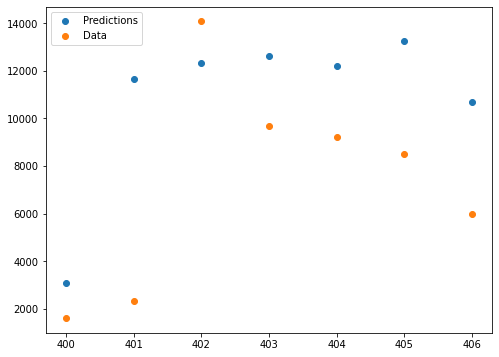

In [ ]:
# nuovi_positivi    totale_ospedalizzati   dimessi_guariti    deceduti

plt.scatter(pred_original_scale.index, pred_original_scale['pred_nuovi_positivi_Lombardia'], label = 'Predictions')
plt.scatter(pred_original_scale.index, df_by_region[reg].iloc[-time_steps_for_test:,:]['nuovi_positivi_Lombardia'], label = 'Data')
plt.legend()

# Comments

The model is doing way better than yesterday (the key thing was to put shuffle=False in the creation of the training dataset). Two problems:
- The network has issues to learn the behaviour of "nuovi_positivi" beacuse the trend is very oscillating. Applying the Savitzky-Golay filter the network performs quite well but has it still struggles.
- IMPORTANT: Since the trend of "deceduti" and "dimessi_guariti" is increasing, we must use pct_change or diff in the model. Otherwise the model will learn to predict in [a,b] with a,b in R, but the next seven days will be surely greater than b!